In [26]:
import sys
import logging
import argparse
import os
import shutil
import importlib.util
import torch
import gym
import copy
import git
import re
from tensorboardX import SummaryWriter
from crowd_sim.envs.utils.robot import Robot
from crowd_nav.utils.trainer import VNRLTrainer, MPRLTrainer
from crowd_nav.utils.memory import ReplayMemory
from crowd_nav.utils.explorer import Explorer
from crowd_nav.policy.policy_factory import policy_factory

In [27]:
from crowd_nav.configs.icra_benchmark.config import BaseEnvConfig, BasePolicyConfig, BaseTrainConfig, Config


class EnvConfig(BaseEnvConfig):
    def __init__(self, debug=False):
        super(EnvConfig, self).__init__(debug)
        self.env.randomize_attributes = True
        self.env.time_step = 0.25
        self.sim.centralized_planning = False
        self.sim.test_scenario = "corner"
        self.sim.human_num = 10
        self.humans.policy = "socialforce"

env_config = EnvConfig(True)
env = gym.make('CrowdSim-v0')
env.configure(env_config)
robot = Robot(env_config, 'robot')
robot.kinematics = "holonomic"
robot.time_step = env.time_step
robot.policy = policy_factory["socialforce"]()
robot.policy.multiagent_training = True
env.set_robot(robot)

# env.set_scene("corner")

In [28]:
rewards = []
ob = env.reset()


[3, 3, 1, 2, 1]
Spawn group 0 of size 3, center: [-5.79785982  2.35304873], goal: [ 1.70214018 -5.14695127]
Spawn group 1 of size 3, center: [-5.50799959  1.87707156], goal: [ 1.99200041 -5.62292844]
Spawn group 2 of size 1, center: [ 2.7378974  -5.53125283], goal: [-4.7621026   1.96874717]
Spawn group 3 of size 2, center: [ 2.57846629 -4.26838776], goal: [-4.92153371  3.23161224]
Spawn group 4 of size 1, center: [ 3.12810072 -5.75311357], goal: [-4.37189928  1.74688643]


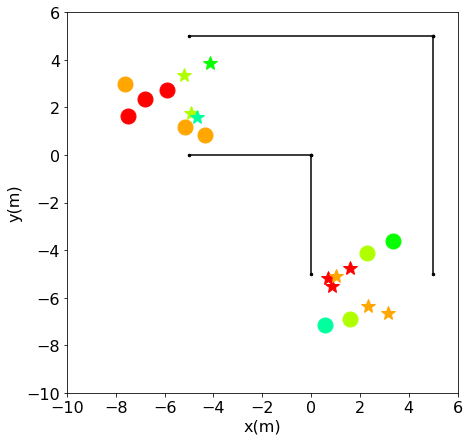

In [29]:
env.render("traj")

In [30]:
env.individual_membership

[6, 9]